In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Importing seaborn for data visualization


In [96]:
!pip install fredapi


In [62]:
import yfinance as yf
import pandas as pd

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Resample the data to get the last trading day of each year
gld_yearly = gld_data['Close'].resample('Y').last()

# Calculate the annual return
gld_annual_return = gld_yearly.pct_change() * 100

# Filter out the years to match Yahoo Finance
gld_annual_return = gld_annual_return[gld_annual_return.index.year >= 2017]

# Display the annual returns
print("Gold (GLD) Annual Returns by Year:")
print(gld_annual_return)


[*********************100%%**********************]  1 of 1 completed

Gold (GLD) Annual Returns by Year:
Date
2017-12-31          NaN
2018-12-31    -1.940964
2019-12-31    17.855665
2020-12-31    24.814561
2021-12-31    -4.148909
2022-12-31    -0.772115
2023-12-31    12.691582
Freq: A-DEC, Name: Close, dtype: float64


# LINEAR REGRESSION

[*********************100%%**********************]  1 of 1 completed


Daily Mean Squared Error: 2.2333762463928718e-09
Daily R^2 Score: 0.9999670812582759
Annualized Predicted Return using linear regression: 17.54%


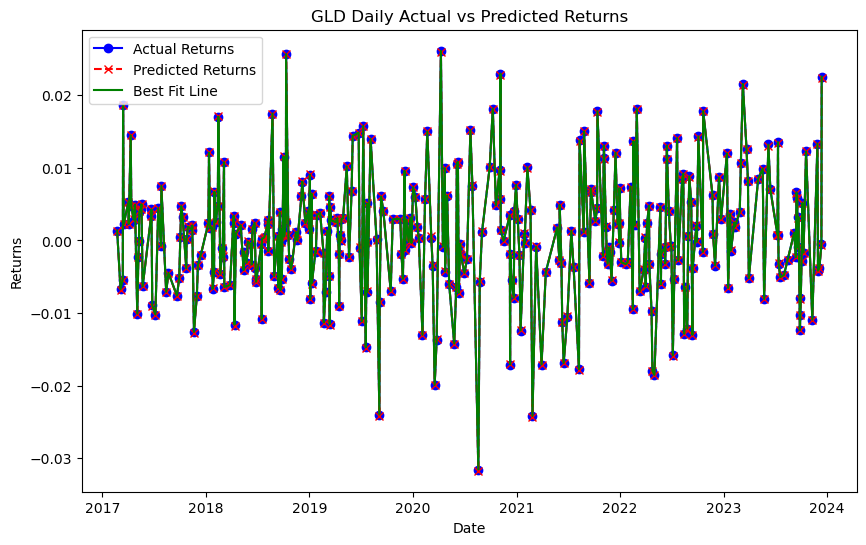

Correlation Matrix:
                  Open      High       Low       RSI  GoldenCross  \
Open          1.000000  0.999701  0.999635  0.048531     0.224726   
High          0.999701  1.000000  0.999579  0.051187     0.224716   
Low           0.999635  0.999579  1.000000  0.050867     0.222809   
RSI           0.048531  0.051187  0.050867  1.000000     0.053986   
GoldenCross   0.224726  0.224716  0.222809  0.053986     1.000000   
Lagged_Close  0.999177  0.998860  0.998764  0.041483     0.224237   
PriceChange   0.003048  0.015705  0.017608  0.245856    -0.008293   
LogReturns   -0.001766  0.010807  0.012604  0.253120    -0.007226   
PriceRatio    0.056970  0.060404  0.061537  0.642422     0.040232   
MACD          0.143718  0.145853  0.141636  0.695624     0.153785   
UpperBand     0.991041  0.991246  0.990510 -0.043937     0.208451   
LowerBand     0.985341  0.984664  0.985542 -0.069823     0.223815   
ATR           0.562557  0.567991  0.557787  0.069401     0.097030   
VolumeChange  

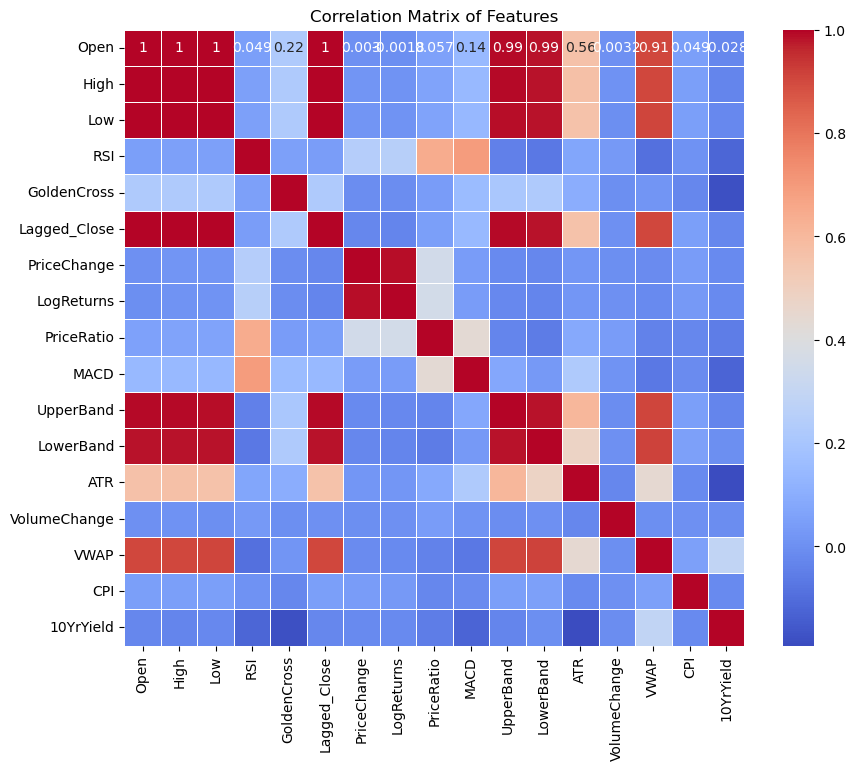

In [134]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fredapi import Fred

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Fetch CPI and 10-Year Treasury Yield data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31').resample('D').ffill().pct_change()
treasury_yield_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31').resample('D').ffill()

# Align CPI and Treasury data with GLD data
gld_data['CPI'] = cpi_data
gld_data['10YrYield'] = treasury_yield_data

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP', 'CPI', '10YrYield']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Split the data into training and testing sets
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

# Train the Linear Regression model on daily data
model_daily = LinearRegression()
model_daily.fit(X_train_daily, y_train_daily)

# Predict returns on the test set
y_pred_lr = model_daily.predict(X_test_daily)

# Evaluate the model
mse_daily = mean_squared_error(y_test_daily, y_pred_lr)
r2_daily = r2_score(y_test_daily, y_pred_lr)

print(f"Daily Mean Squared Error: {mse_daily}")
print(f"Daily R^2 Score: {r2_daily}")

# Annualize the predicted returns
trading_days = 252  # Number of trading days in a year
mean_daily_return_lr = np.mean(y_pred_lr)
annualized_predicted_return_lr = (1 + mean_daily_return_lr) ** trading_days - 1

print(f"Annualized Predicted Return using linear regression: {annualized_predicted_return_lr:.2%}")

# Sort data for plotting
y_test_daily_sorted = y_test_daily.sort_index()
y_pred_daily_sorted = pd.Series(y_pred_lr, index=y_test_daily.index).sort_index()

# Plot the actual and predicted returns
plt.figure(figsize=(10, 6))
plt.plot(y_test_daily_sorted.index, y_test_daily_sorted, label='Actual Returns', color='blue', marker='o')
plt.plot(y_pred_daily_sorted.index, y_pred_daily_sorted, label='Predicted Returns', color='red', linestyle='--', marker='x')

# Add a line of best fit for predicted returns
z_daily = np.polyfit(y_test_daily_sorted, y_pred_daily_sorted, 1)
p_daily = np.poly1d(z_daily)
plt.plot(y_test_daily_sorted.index, p_daily(y_test_daily_sorted), label='Best Fit Line', color='green', linestyle='-')

plt.title('GLD Daily Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Create a correlation matrix
corr_matrix = X_daily.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


# RANDOM FOREST

In [118]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import numpy as np
from fredapi import Fred

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Split the data into training and testing sets
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reg.fit(X_train_daily, y_train_daily)

# Predict returns on the test set
y_pred_rf_reg = rf_model_reg.predict(X_test_daily)

# Evaluate the regressor model
mse_rf = mean_squared_error(y_test_daily, y_pred_rf_reg)
r2_rf = r2_score(y_test_daily, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Convert the returns to binary classes for classification (1 if return > 0, else 0)
y_daily_class = (y_daily > 0).astype(int)

# Split the data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_daily, y_daily_class, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_class.fit(X_train_class, y_train_class)

# Predict classes on the test set
y_pred_rf_class = rf_model_class.predict(X_test_class)

# Evaluate the classifier model
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_class)
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_rf_class))

# Annualize the predicted returns
trading_days = 252  # Number of trading days in a year
mean_daily_return_rf = np.mean(y_pred_rf_reg)
annualized_predicted_return_rf = (1 + mean_daily_return_rf) ** trading_days - 1

print(f"Annualized Predicted Return using Random Forest Regressor: {annualized_predicted_return_rf:.2%}")


[*********************100%%**********************]  1 of 1 completed


Random Forest Regressor Mean Squared Error: 4.7428539307452276e-08
Random Forest Regressor R^2 Score: 0.9993009293269189
Random Forest Classifier Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       1.00      1.00      1.00       183

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Annualized Predicted Return using Random Forest Regressor: 17.43%


## RANDOM FOREST WITH PCA

[*********************100%%**********************]  1 of 1 completed


Explained Variance Ratio by each Principal Component:
[0.42400698 0.15889355 0.10056925 0.07013217 0.05929513 0.05858327
 0.0514454  0.03340117]

PCA Component Loadings:
         Open      High       Low       RSI  GoldenCross  Lagged_Close  \
PC1  0.371305  0.371427  0.371163  0.009961     0.084982      0.371266   
PC2  0.010169  0.015873  0.015290  0.478028     0.063937     -0.002837   
PC3  0.005394 -0.000028 -0.004523  0.302615     0.209840      0.021058   
PC4 -0.004062 -0.000802 -0.004923 -0.238531     0.489535     -0.009889   
PC5  0.006695  0.008584  0.001781  0.027468    -0.036840      0.006580   
PC6 -0.004422 -0.008652 -0.001059  0.062938    -0.155454     -0.003583   
PC7 -0.014652 -0.010701 -0.018389 -0.031513    -0.760683     -0.014033   
PC8 -0.084198 -0.075572 -0.088716 -0.143450     0.232317     -0.085428   

     PriceChange  LogReturns  PriceRatio      MACD  UpperBand  LowerBand  \
PC1    -0.000769   -0.002544    0.014005  0.049099   0.370512   0.365535   
PC2     0.4

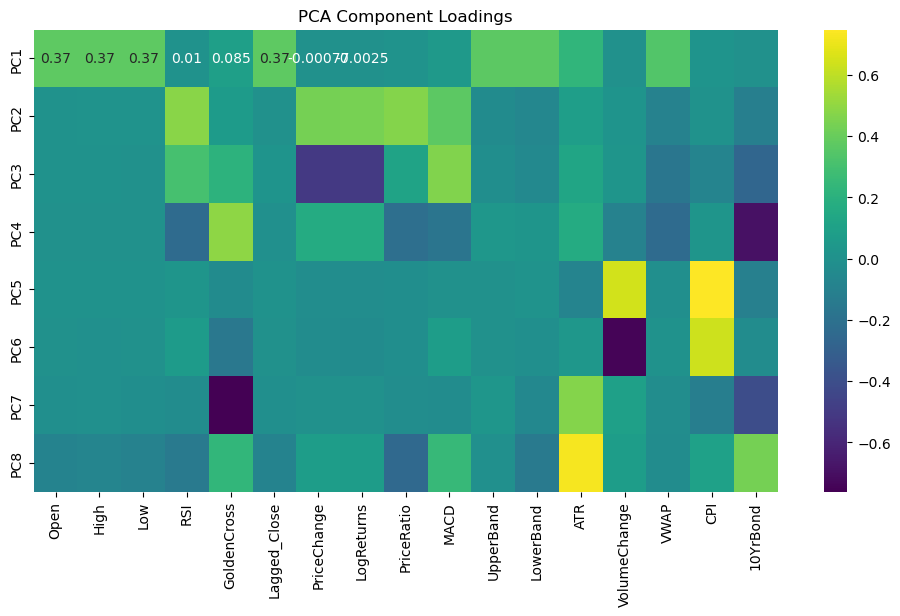

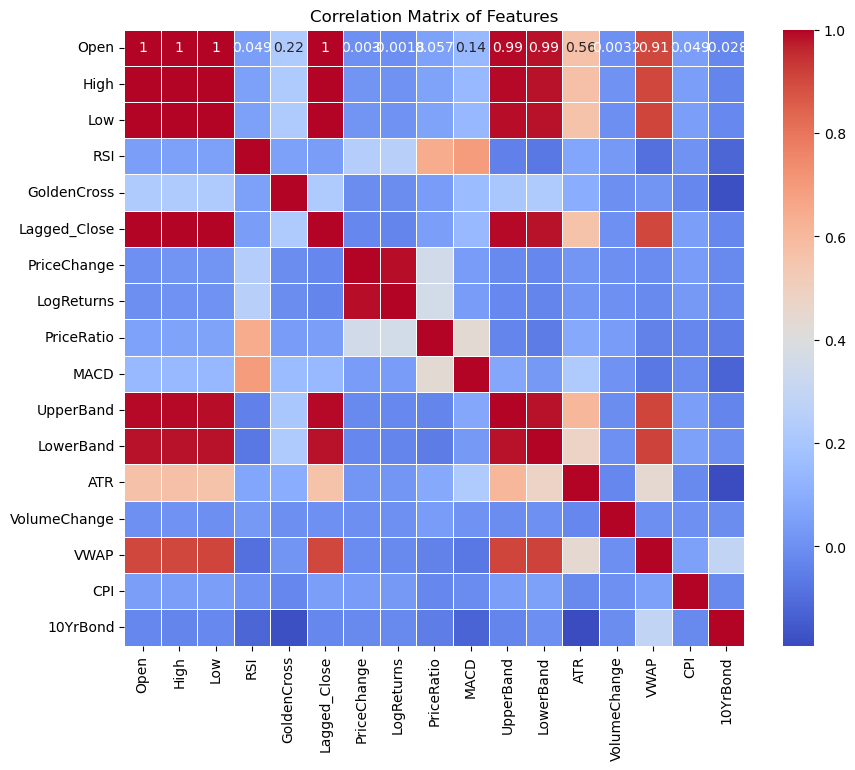

Random Forest Regressor Mean Squared Error: 2.1486103811520563e-06
Random Forest Regressor R^2 Score: 0.9683306606681645
Annualized Predicted Return using Random Forest Regressor: 11.84%
Random Forest Classifier Accuracy: 0.9393063583815029
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       163
           1       0.93      0.96      0.94       183

    accuracy                           0.94       346
   macro avg       0.94      0.94      0.94       346
weighted avg       0.94      0.94      0.94       346



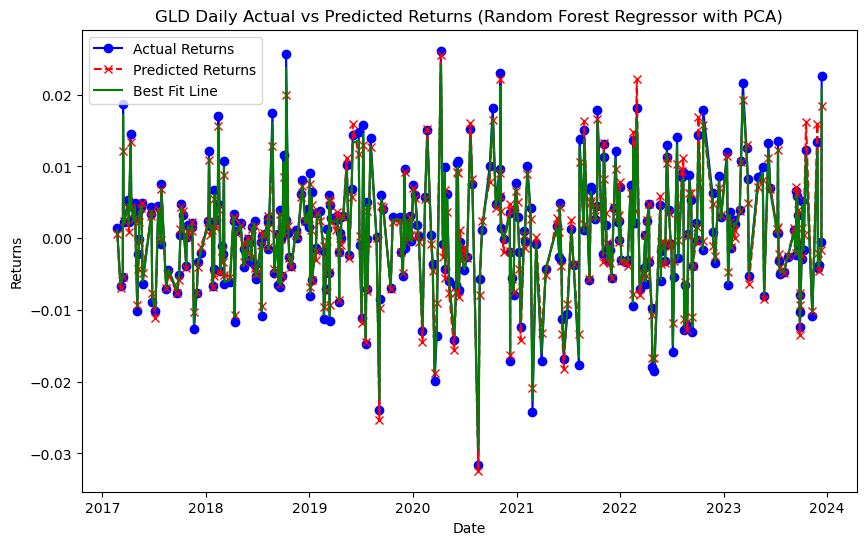

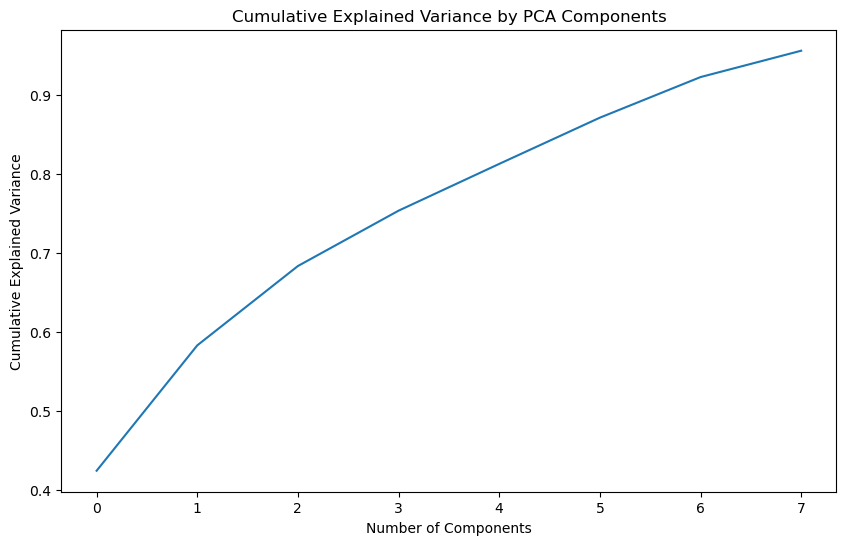

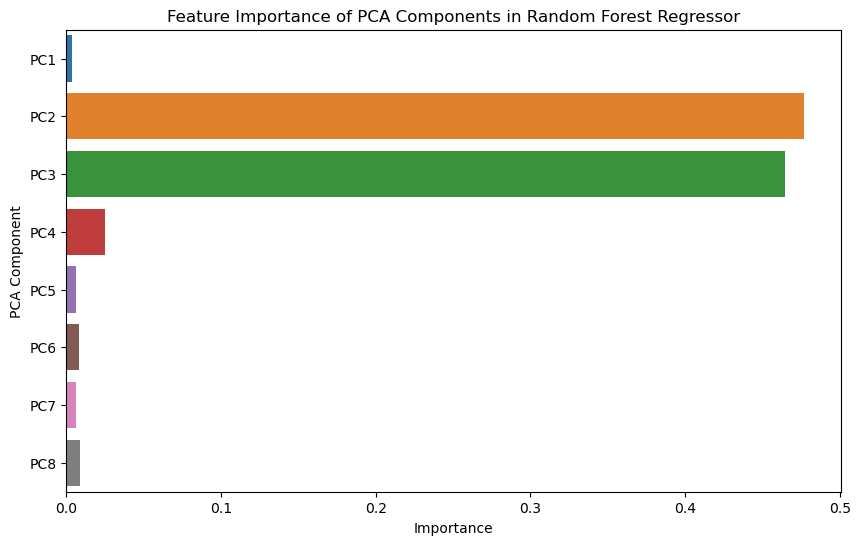

In [136]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fredapi import Fred

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Apply PCA to retain more components (e.g., capturing 95% of the variance)
pca = PCA(n_components=0.95)  # This retains components that explain 95% of the variance
X_daily_pca = pca.fit_transform(X_daily_scaled)

# Display the explained variance ratio of each component
print("Explained Variance Ratio by each Principal Component:")
print(pca.explained_variance_ratio_)

# Inspect PCA components (optional)
# Create a DataFrame to see the contribution of each feature to the principal components
pca_components_df = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print("\nPCA Component Loadings:")
print(pca_components_df)

# Plot heatmap of the PCA components
plt.figure(figsize=(12, 6))
sns.heatmap(pca_components_df, cmap='viridis', annot=True)
plt.title('PCA Component Loadings')
plt.show()

# Correlation Matrix
corr_matrix = pd.DataFrame(X_daily_scaled, columns=features).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Split the data into training and testing sets
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily_pca, y_daily, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reg.fit(X_train_daily, y_train_daily)

# Predict returns on the test set
y_pred_rf_reg = rf_model_reg.predict(X_test_daily)

# Evaluate the regressor model
mse_rf = mean_squared_error(y_test_daily, y_pred_rf_reg)
r2_rf = r2_score(y_test_daily, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Annualize the predicted returns
trading_days = 252  # Number of trading days in a year
mean_daily_return_rf = np.mean(y_pred_rf_reg)
annualized_predicted_return_rf = (1 + mean_daily_return_rf) ** trading_days - 1

print(f"Annualized Predicted Return using Random Forest Regressor: {annualized_predicted_return_rf:.2%}")

# Convert the returns to binary classes for classification (1 if return > 0, else 0)
y_daily_class = (y_daily > 0).astype(int)

# Split the data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_daily_pca, y_daily_class, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_class.fit(X_train_class, y_train_class)

# Predict classes on the test set
y_pred_rf_class = rf_model_class.predict(X_test_class)

# Evaluate the classifier model
accuracy_rf = accuracy_score(y_test_class, y_pred_rf_class)
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_rf_class))

# Plotting the actual vs predicted returns for the regressor
plt.figure(figsize=(10, 6))
y_test_daily_sorted = y_test_daily.sort_index()
y_pred_rf_reg_sorted = pd.Series(y_pred_rf_reg, index=y_test_daily.index).sort_index()
plt.plot(y_test_daily_sorted.index, y_test_daily_sorted, label='Actual Returns', color='blue', marker='o')
plt.plot(y_pred_rf_reg_sorted.index, y_pred_rf_reg_sorted, label='Predicted Returns', color='red', linestyle='--', marker='x')

# Add a line of best fit for predicted returns
z_rf = np.polyfit(y_test_daily_sorted, y_pred_rf_reg_sorted, 1)
p_rf = np.poly1d(z_rf)
plt.plot(y_test_daily_sorted.index, p_rf(y_test_daily_sorted), label='Best Fit Line', color='green', linestyle='-')

plt.title('GLD Daily Actual vs Predicted Returns (Random Forest Regressor with PCA)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Display the explained variance by each PCA component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.show()

# Feature importance for PCA components
pca_feature_importances = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(pca.n_components_)],
    'Importance': rf_model_reg.feature_importances_
})

# Visualize feature importance of PCA components
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='PCA Component', data=pca_feature_importances)
plt.title('Feature Importance of PCA Components in Random Forest Regressor')
plt.show()


# Recursive Feature Elimination (RFE) and Lasso Regression (L1 Regularization)

[*********************100%%**********************]  1 of 1 completed


Selected Features by Lasso: Index(['LogReturns'], dtype='object')
R^2 Score using Lasso: 0.999734930003591


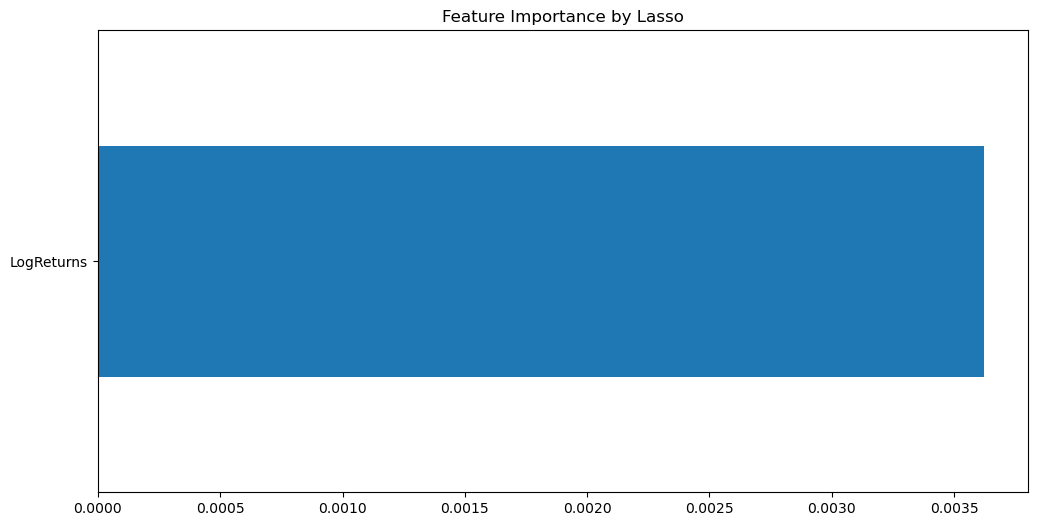

In [138]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'GoldenCross', 'Lagged_Close', 'PriceChange', 'LogReturns',
            'PriceRatio', 'MACD', 'UpperBand', 'LowerBand', 'ATR', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

### Lasso Regression (L1 Regularization) for Feature Selection ###
lasso = Lasso(alpha=0.005)  # Regularization strength
lasso.fit(X_daily_scaled, y_daily)

# Get coefficients of features
lasso_coefficients = pd.Series(lasso.coef_, index=X_daily.columns)
selected_features_lasso = lasso_coefficients[lasso_coefficients != 0].index

# Debugging: Check if any features were selected
if selected_features_lasso.empty:
    print("No features were selected by Lasso. Consider adjusting the alpha parameter.")
else:
    print("Selected Features by Lasso:", selected_features_lasso)

    # Train the model using the selected features from Lasso
    X_selected_lasso = X_daily[selected_features_lasso]
    X_selected_lasso_scaled = scaler.fit_transform(X_selected_lasso)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_selected_lasso_scaled, y_daily)

    # Evaluate Lasso model
    y_pred_rf_lasso = rf_model.predict(X_selected_lasso_scaled)
    r2_rf_lasso = r2_score(y_daily, y_pred_rf_lasso)
    print(f"R^2 Score using Lasso: {r2_rf_lasso}")

    ### Visualizing the Importance of Features Selected by Lasso ###
    plt.figure(figsize=(12, 6))
    lasso_coefficients[lasso_coefficients != 0].sort_values().plot(kind='barh')
    plt.title('Feature Importance by Lasso')
    plt.show()


# MODELS AFTER FEATURE REDUCTION
removed logreturns

In [178]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'LogReturns',
            'PriceRatio', 'MACD', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_daily_scaled, y_daily, test_size=0.2, random_state=42)

# Train and evaluate a Linear Regression model (without PCA)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate and print evaluation metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression Mean Absolute Error: {mae_lr}")
print(f"Linear Regression R^2 Score: {r2_lr}")

# Calculate the number of trading days in a year
trading_days = 252

# Calculate the mean of daily returns predicted by the Linear Regression model
mean_daily_return_lr = y_pred_lr.mean()

# Annualize the return
annualized_return_lr = mean_daily_return_lr * trading_days
print(f"Annualized Expected Return using Linear Regression: {annualized_return_lr}")

# Apply PCA only to the Random Forest model
pca = PCA(n_components=0.95)  # Retain components that explain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate the Random Forest Regressor model with PCA-transformed features
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf.fit(X_train_pca, y_train)
y_pred_rf_reg = best_rf.predict(X_test_pca)

# Calculate and print evaluation metrics for Random Forest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test, y_pred_rf_reg)
r2_rf = r2_score(y_test, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor Mean Absolute Error: {mae_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Calculate the mean of daily returns predicted by the Random Forest model
mean_daily_return_rf = y_pred_rf_reg.mean()

# Annualize the return
annualized_return_rf = mean_daily_return_rf * trading_days
print(f"Annualized Expected Return using Random Forest Regressor: {annualized_return_rf}")


[*********************100%%**********************]  1 of 1 completed


Linear Regression Mean Squared Error: 6.765671289816793e-09
Linear Regression Mean Absolute Error: 3.63669038477051e-05
Linear Regression R^2 Score: 0.9999111196011822
Annualized Expected Return using Linear Regression: 0.03621283583264699
Random Forest Regressor Mean Squared Error: 5.19134071702088e-06
Random Forest Regressor Mean Absolute Error: 0.001412479929510832
Random Forest Regressor R^2 Score: 0.9318015295803224
Annualized Expected Return using Random Forest Regressor: 0.046515074290231787


## CROSS VALIDATION

In [180]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fredapi import Fred

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'LogReturns',
            'PriceRatio', 'MACD', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Apply PCA to the data
pca = PCA(n_components=0.95)  # Retain components that explain 95% of variance
X_daily_pca = pca.fit_transform(X_daily_scaled)

# Use TimeSeriesSplit for cross-validation (better suited for time-series data)
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation for Linear Regression
lr_model = LinearRegression()
lr_cv_scores = cross_val_score(lr_model, X_daily_pca, y_daily, cv=tscv, scoring='r2')

# Perform cross-validation for Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_daily_pca, y_daily, cv=tscv, scoring='r2')

# Print the cross-validation scores for Linear Regression
print(f"Linear Regression Cross-validated R^2 scores: {lr_cv_scores}")
print(f"Mean R^2 (Linear Regression): {lr_cv_scores.mean()}")
print(f"Standard Deviation of R^2 (Linear Regression): {lr_cv_scores.std()}")

# Print the cross-validation scores for Random Forest Regressor
print(f"Random Forest Regressor Cross-validated R^2 scores: {rf_cv_scores}")
print(f"Mean R^2 (Random Forest Regressor): {rf_cv_scores.mean()}")
print(f"Standard Deviation of R^2 (Random Forest Regressor): {rf_cv_scores.std()}")


[*********************100%%**********************]  1 of 1 completed


Linear Regression Cross-validated R^2 scores: [0.99846852 0.99827393 0.9955855  0.99821094 0.99711756]
Mean R^2 (Linear Regression): 0.9975312884887021
Standard Deviation of R^2 (Linear Regression): 0.001081582126311399
Random Forest Regressor Cross-validated R^2 scores: [0.65989067 0.45003998 0.7283083  0.87046733 0.58497514]
Mean R^2 (Random Forest Regressor): 0.6587362816842564
Standard Deviation of R^2 (Random Forest Regressor): 0.14047525615898912


# GridSearchCV
Further optimze the RF to make it more effective

In [182]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'LogReturns',
            'PriceRatio', 'MACD', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Apply PCA to retain more components (e.g., capturing 95% of the variance)
pca = PCA(n_components=0.95)
X_daily_pca = pca.fit_transform(X_daily_scaled)

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Scorer for GridSearchCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring=mse_scorer, cv=5, n_jobs=-1, verbose=2)

# Fit the model with GridSearchCV
grid_search.fit(X_daily_pca, y_daily)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score (Negative MSE): {-grid_search.best_score_}")

# Get the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
X_train, X_test, y_train, y_test = train_test_split(X_daily_pca, y_daily, test_size=0.2, random_state=42)
y_pred_rf = best_rf.predict(X_test)

# Calculate and print evaluation metrics for the best Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Best Random Forest Regressor R^2 Score: {r2_rf}")


[*********************100%%**********************]  1 of 1 completed


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (Negative MSE): 1.3469964595844422e-05
Best Random Forest Regressor Mean Squared Error: 9.537245949055017e-07
Best Random Forest Regressor R^2 Score: 0.9874709517021438


# ENSEMBLE THE MODELS
combining LR and RF models together to increase predictability

In [184]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Your FRED API Key
fred_api_key = '5dc6e077bceb77f1cfdde2f8702b2974'

# Initialize the FRED client
fred = Fred(api_key=fred_api_key)

# Fetch historical Gold (GLD) data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Fetch CPI data from FRED
cpi_data = fred.get_series('CPIAUCSL', start='2017-01-01', end='2023-12-31')
cpi_data = cpi_data.resample('D').ffill().pct_change()

# Fetch 10-Year US Government Bond Interest Rate from FRED
bond_data = fred.get_series('DGS10', start='2017-01-01', end='2023-12-31')
bond_data = bond_data.resample('D').ffill()

# Merge all data into a single DataFrame
gld_data['CPI'] = cpi_data
gld_data['10YrBond'] = bond_data

# Calculate RSI
delta = gld_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gld_data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Averages for Golden Cross
gld_data['MA50'] = gld_data['Close'].rolling(window=50).mean()
gld_data['MA200'] = gld_data['Close'].rolling(window=200).mean()

# Create Golden Cross indicator (1 if MA50 > MA200, else 0)
gld_data['GoldenCross'] = np.where(gld_data['MA50'] > gld_data['MA200'], 1, 0)

# Calculate additional features
gld_data['PriceChange'] = gld_data['Close'].diff(1)
gld_data['LogReturns'] = np.log(gld_data['Close'] / gld_data['Close'].shift(1))
gld_data['PriceRatio'] = gld_data['Close'] / gld_data['Close'].shift(7)  # 7-day ratio
gld_data['EMA12'] = gld_data['Close'].ewm(span=12, adjust=False).mean()
gld_data['EMA26'] = gld_data['Close'].ewm(span=26, adjust=False).mean()
gld_data['MACD'] = gld_data['EMA12'] - gld_data['EMA26']
gld_data['20SMA'] = gld_data['Close'].rolling(window=20).mean()
gld_data['StdDev'] = gld_data['Close'].rolling(window=20).std()
gld_data['UpperBand'] = gld_data['20SMA'] + (gld_data['StdDev'] * 2)
gld_data['LowerBand'] = gld_data['20SMA'] - (gld_data['StdDev'] * 2)
gld_data['ATR'] = gld_data['High'].rolling(window=14).max() - gld_data['Low'].rolling(window=14).min()
gld_data['VolumeChange'] = gld_data['Volume'].diff(1)
gld_data['VWAP'] = (gld_data['Volume'] * gld_data['Close']).cumsum() / gld_data['Volume'].cumsum()

# Calculate the lagged closing price (previous day's closing price)
gld_data['Lagged_Close'] = gld_data['Close'].shift(1)

# Calculate daily returns (percentage change in closing prices)
gld_data['Return'] = gld_data['Close'].pct_change()

# Prepare the data with all specified features and returns as the target variable
features = ['Open', 'High', 'Low', 'RSI', 'LogReturns',
            'PriceRatio', 'MACD', 'VolumeChange', 'VWAP', 'CPI', '10YrBond']

# Drop rows with NaN values in both features and target
data = gld_data[features + ['Return']].dropna()

# Split the features and target
X_daily = data[features]
y_daily = data['Return']

# Standardize the data
scaler = StandardScaler()
X_daily_scaled = scaler.fit_transform(X_daily)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_daily_scaled, y_daily, test_size=0.2, random_state=42)

# Train and evaluate a Linear Regression model (without PCA)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate and print evaluation metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression Mean Absolute Error: {mae_lr}")
print(f"Linear Regression R^2 Score: {r2_lr}")

# Calculate the number of trading days in a year
trading_days = 252

# Calculate the mean of daily returns predicted by the Linear Regression model
mean_daily_return_lr = y_pred_lr.mean()

# Annualize the return
annualized_return_lr = mean_daily_return_lr * trading_days
print(f"Annualized Expected Return using Linear Regression: {annualized_return_lr}")

# Apply PCA only to the Random Forest model
pca = PCA(n_components=0.95)  # Retain components that explain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate the Random Forest Regressor model with PCA-transformed features
best_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)
best_rf.fit(X_train_pca, y_train)
y_pred_rf_reg = best_rf.predict(X_test_pca)

# Calculate and print evaluation metrics for Random Forest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test, y_pred_rf_reg)
r2_rf = r2_score(y_test, y_pred_rf_reg)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor Mean Absolute Error: {mae_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Calculate the mean of daily returns predicted by the Random Forest model
mean_daily_return_rf = y_pred_rf_reg.mean()

# Annualize the return
annualized_return_rf = mean_daily_return_rf * trading_days
print(f"Annualized Expected Return using Random Forest Regressor: {annualized_return_rf}")

# Ensemble: Weighted Average of Linear Regression and Random Forest Regressor
# Assign more weight to the Random Forest model as it performs better
weight_lr = 0.5173
weight_rf = 0.4827

# Combined predictions
y_pred_ensemble = (weight_rf * y_pred_rf_reg) + (weight_lr * y_pred_lr)

# Calculate and print evaluation metrics for the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble Model Mean Squared Error: {mse_ensemble}")
print(f"Ensemble Model Mean Absolute Error: {mae_ensemble}")
print(f"Ensemble Model R^2 Score: {r2_ensemble}")

# Calculate the mean of daily returns predicted by the Ensemble model
mean_daily_return_ensemble = y_pred_ensemble.mean()

# Annualize the return
annualized_return_ensemble = mean_daily_return_ensemble * trading_days
print(f"Annualized Expected Return using Ensemble Model: {annualized_return_ensemble}")


[*********************100%%**********************]  1 of 1 completed


Linear Regression Mean Squared Error: 6.765671289816793e-09
Linear Regression Mean Absolute Error: 3.63669038477051e-05
Linear Regression R^2 Score: 0.9999111196011822
Annualized Expected Return using Linear Regression: 0.03621283583264699
Random Forest Regressor Mean Squared Error: 5.145722839079759e-06
Random Forest Regressor Mean Absolute Error: 0.0014097477211744906
Random Forest Regressor R^2 Score: 0.9324008101263239
Annualized Expected Return using Random Forest Regressor: 0.045634908183096026
Ensemble Model Mean Squared Error: 1.1725865645043172e-06
Ensemble Model Mean Absolute Error: 0.0006790707902190056
Ensemble Model R^2 Score: 0.9845957692833249
Annualized Expected Return using Ensemble Model: 0.04076087015620875


# PREDICTED ANNUAL RETURNS

In [188]:
import yfinance as yf

# Fetch historical GOLD data in daily timeframe
gld_data = yf.download('GLD', start='2017-01-01', end='2023-12-31')

# Get the initial and final closing prices
initial_price = gld_data['Close'].iloc[0]
final_price = gld_data['Close'].iloc[-1]

# Calculate the number of years
n_years = (gld_data.index[-1] - gld_data.index[0]).days / 365.25

# Calculate the cumulative return
cumulative_return = final_price / initial_price - 1

# Calculate the actual annualized return
actual_annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1

# Convert to percentage
actual_annualized_return_percentage = actual_annualized_return * 100

print(f"Actual Annualized Return (2017-2023): {actual_annualized_return_percentage:.2f}%")


[*********************100%%**********************]  1 of 1 completed

Actual Annualized Return (2017-2023): 8.17%
